## Description

The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. 


Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

### import Libraries and Initialise setting

In [205]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import math
import random
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from tqdm import tqdm_notebook as tqdm
from sklearn import svm
from sklearn.metrics import *
import plotly.offline as py
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

%matplotlib inline

mpl.rcParams['figure.figsize'] = (10,5)
mpl.rc('xtick', labelsize = 15) 
mpl.rc('ytick', labelsize = 15)

font = {'size'   : 15}
mpl.rc('font', **font)

### Load Data

In [168]:
# get data
test  = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')


In [169]:
# divide into X and y data
X_train = train.iloc[:,1:train.shape[1]]
y_train = train.iloc[:,0]

#slpit into 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

n_train,m_train = X_train.shape
n_val, m_val = X_val.shape
n_test,m_test = X_test.shape

print('TRAINING DATA')
print('Number of features (m): %.0f'%(m_train))
print('Number of traiing samples (n): %.0f'%(n_train))


print('\nVALIDATION DATA')
print('Number of features (m): %.0f'%(m_val))
print('Number of traiing samples (n): %.0f'%(n_val))


print('\nTEST DATA')
print('Number of features (m): %.0f'%(m_test))
print('Number of traiing samples (n): %.0f'%(n_test))

TRAINING DATA
Number of features (m): 784
Number of traiing samples (n): 31500

VALIDATION DATA
Number of features (m): 784
Number of traiing samples (n): 10500

TEST DATA
Number of features (m): 784
Number of traiing samples (n): 28000


### Helper Functions

In [183]:
# Plot images in an M x N subplot
def PlotSamples(N_samples, X_train, y_train):
    
    n_train, m_train = X_train.shape
        
    rows = int(round(np.sqrt(N_samples)))
    columns = math.ceil(N_samples/rows)
    
    sample_i = random.sample(range(0, n_train), N_samples)
    mpl.rcParams['figure.figsize'] = [9,9]
        
    f, ax = plt.subplots(rows, columns)
    plt.tight_layout(pad = 0.2, w_pad = .1, h_pad=.1)
   
    for i in range(0, rows * columns):
    
        if i < N_samples:
                
                data = X_train.iloc[sample_i[i],:].values #this is the first number
                pix_rows, pix_cols = 28, 28
                grid = data.reshape((pix_rows, pix_cols))
                ax[i // columns, i % columns].imshow(grid)
                ax[i // columns, i % columns].axis('off') 
                ax[i // columns, i % columns].set_title(y_train.values[sample_i[i]])
                
        else:
                ax[i // columns, i % columns].axis('off')

 #PLotting eigne values
def PlotEigen(N_components, eigen_val_pca):

    rows = int(round(np.sqrt(N_components)))

    columns = math.ceil(N_components/rows)

    # mpl.rcParams['figure.figsize'] = [11,11]
    plt.figure(figsize = [11,11])
    for i in list(range(rows * columns)):
        if i < N_components:
            plt.subplot(rows, columns, i + 1)
            plt.imshow(eigen_val_pca[i].reshape(28, 28), cmap = 'jet')
            title_text = 'Eigenvalue #' + str(i + 1)
            plt.title(title_text, size = 10)
            plt.xticks(())
            plt.yticks(())

    plt.show()
    

def PCArun(N_components, X_std):
     
    pca = PCA(n_components = N_components, svd_solver = 'auto', whiten = True)
    pca.fit(X_std)
    explain_ratio = pca.explained_variance_ratio_.sum() * 100
    eigen_val_pca = pca.components_
    
    return (pca, explain_ratio)


def PCA_Eigen(N_components, X_std):
     
    pca = PCA(n_components = N_components, svd_solver = 'auto', whiten = True)
    pca.fit(X_std)
    
    eigen_val_pca = pca.components_
    
    return (pca, eigen_val_pca)


#Plots the fitted test results
def PlotTest(N_samples, X_test, y_test_pred):

    n_test,m_test = X_test.shape

    rows = int(round(np.sqrt(N_samples)))

    columns = math.ceil(N_samples/rows)

    sample_i = random.sample(range(0,n_test), N_samples)
    mpl.rcParams['figure.figsize'] = [11,11]

    f, ax = plt.subplots(rows, columns)
    plt.tight_layout(pad = 0.2, w_pad = .1, h_pad=.1)

    for i in range(0, rows * columns):

        if i < N_samples:
                # Create a 1024 x 1024 x 3 array of 8 bit unsigned integers
                data = X_test.iloc[sample_i[i],:].values #this is the first number
                pix_rows, pix_cols = 28, 28
                grid = data.reshape((pix_rows, pix_cols))
                ax[i // columns, i % columns].imshow(grid)
                ax[i // columns, i % columns].axis('off') 
                ax[i // columns, i % columns].set_title('Predicted: ' + str(y_test_pred[sample_i[i]]))

        else:
                ax[i // columns, i % columns].axis('off')



Randomly selected samples with their assigned labels:


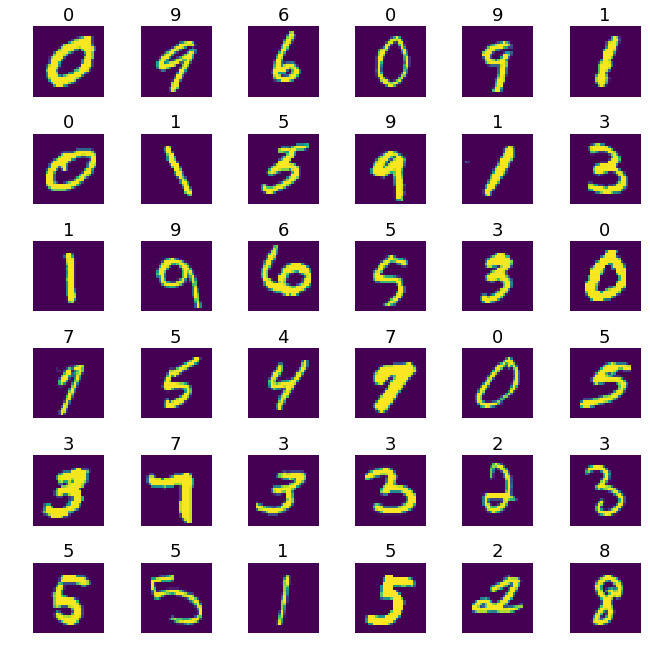

In [171]:
print('Randomly selected samples with their assigned labels:')
PlotSamples(36, X_train, y_train)


### Label Distribution

it is always wise to check the distribution of the labels. As can be seen below, the distribition of pretty much even. this is good for training 


Counts in ascending order:
5    2844
4    3033
8    3035
6    3092
2    3123
0    3137
9    3141
3    3280
7    3302
1    3513
Name: label, dtype: int64


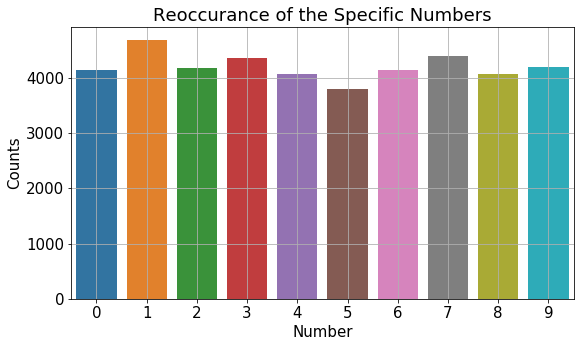

In [172]:
counts = y_train.value_counts().sort_values(ascending = True) 
print('Counts in ascending order:')
print(counts)

#mpl.rcParams['figure.figsize'] = (10,5)
plt.figure(figsize = [9,5])
sns.countplot(x = 'label', data = train);
plt.ylabel('Counts')
plt.xlabel("Number")
plt.title('Reoccurance of the Specific Numbers')
plt.grid(True)

## Principal Component Analysis (PCA)


Principal Component Analysis (PCA)

In a nutshell, PCA is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features ( or subspace ) while still retaining most of the information. To do this the algorithm tries to find the most appropriate directions/angles ( which are the principal components ) that maximise the variance in the new subspace.

In this case goal is to reduce the dimensions of a d-dimensional dataset by projecting it onto a (k)-dimensional subspace (where k << d) in order to increase the computational efficiency while retaining most of the information.

for more information on this topic see: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

### PCA  Pre-processing

In [176]:
# Normalisation:
X_train_std = StandardScaler().fit_transform(X_train) 
X_val_std = StandardScaler().fit_transform(X_val) 
X_test_std = StandardScaler().fit_transform(X_test) 

### PCA from Basic Principals

this section is not really needed but it allowed me to understand the PCA library much better

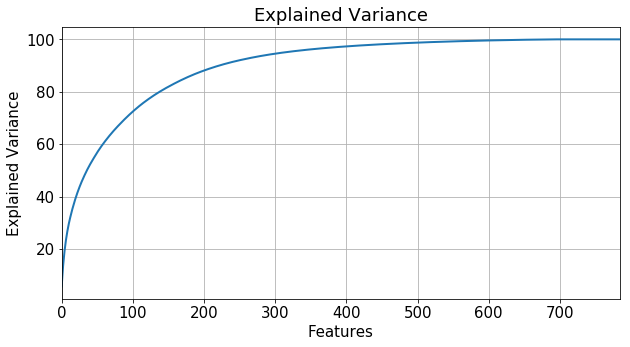

In [174]:

# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_train_std, axis = 0)
covariance_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(covariance_mat)

# Create a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [ (np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eigen_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
total = sum(eigen_vals)
variance_exp = [(i / total) * 100 for i in sorted(eigen_vals, reverse = True)] # Individual explained variance
cumulative_variance_exp = np.cumsum(variance_exp) # Cumulative explained variance

plt.figure(figsize = [10,5])
plt.plot(list(range(m_train)),cumulative_variance_exp, linewidth = 2)
plt.xlabel('Features')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.xlim(0,m_train)
plt.title('Explained Variance')


Takeaway from the Plot:

The plot above shows the distribution of the Explained variances across all features (i.e. pixels) As we can see, out of the 784 features, approximately 90% of the Explained Variance can be described by using just less than 150 features. So if one wanted to implement a PCA on this, extracting the top 150 features would be a very logical choice as they already account for the majority of the data. 

In the section below, I will use the immensely powerful Sklearn toolkit and its built-in PCA method. Unfortunately for brevity I will not be covering how to implement PCA from scratch, partly due to the multitude of resources already available. 

### PCA from SK-Learn

In [164]:
#Variance
N_list = range(1, m_train, 50)
explain_ratio = np.zeros(len(N_list))
cnt = 0

for i in tqdm(N_list):
     _, explain_ratio[cnt] = PCArun(i, X_train_std)
    cnt = cnt + 1


A Jupyter Widget

(0, 105)

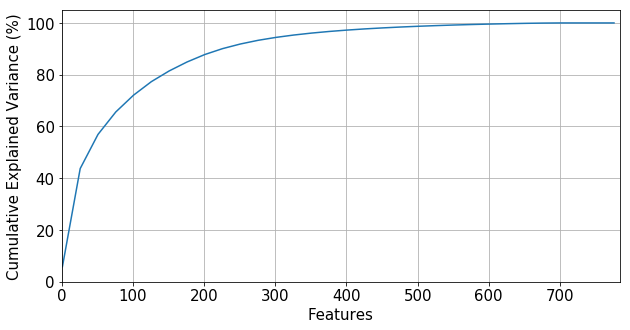

In [163]:
plt.figure(figsize = [10,5])
plt.figure
plt.plot(N_list, explain_ratio)
plt.xlabel('Features')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.xlim(0, m_train)
plt.ylim(0,105)

the two plots above showing the cumulative explained variance match prefetly as is expected. Usually when applying PCA we required that the components will 80% of the variance. therefore we will select 150 components

### Apply PCA  & SVM to Data

the PCA method seeks to obtain the optimal directions (or eigenvectors) that captures the most variance ( spreads out the data points the most). Therefore it may be informative to visualise these directions and their associated eigenvalues.


In [209]:

N_components = 25
print('Reducing dimensions...')
(pca, explain_ratio) = PCArun(N_components, X_train_std)

# Apply the learned PCA model to all the data
print('Applying PCA to data...')
X_train_pca = pca.transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

# Apply classifcation model
print('Train data using SVM...')
svm_model = svm.SVC()
svm_model.fit(X_train_pca, y_train)

# predict the labels values 
print('Predict labels using the PCA-SVM algorithm')
y_train_pred = svm_model.predict(X_train_pca)
y_val_pred = svm_model.predict(X_val_pca)
y_test_pred = svm_model.predict(X_test_pca)

f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')
    
print('\nPCA SUMMARY')
print('Number of components: %.2f'%(N_components))
print('Explained Variance Ratio: %.2f %%'%(explain_ratio))


print('\nTRAINING RESULTS')
print('Training f1 score: %.2f %%'%(f1_train))
print(classification_report(y_train_pred, y_train))

print('\nVALIDATION RESULTS:')
print('Validation f1 score: %.2f %%'%(f1_val))
print(classification_report(y_val_pred, y_val))


Reducing dimensions...
Applying PCA to data...
Train data using SVM...
Predict labels using the PCA-SVM algorithm

PCA SUMMARY
Number of components: 25.00
Explained Variance Ratio: 42.96 %

TRAINING RESULTS
Training f1 score: 0.97 %
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      3148
          1       0.99      0.99      0.99      3529
          2       0.98      0.98      0.98      3134
          3       0.96      0.97      0.96      3256
          4       0.97      0.97      0.97      3045
          5       0.97      0.97      0.97      2839
          6       0.99      0.98      0.99      3101
          7       0.96      0.97      0.97      3279
          8       0.96      0.97      0.96      3023
          9       0.95      0.95      0.95      3146

avg / total       0.97      0.97      0.97     31500


VALIDATION RESULTS:
Validation f1 score: 0.96 %
             precision    recall  f1-score   support

          0       0.98   

### Optimisation of the number of PCA components

A Jupyter Widget

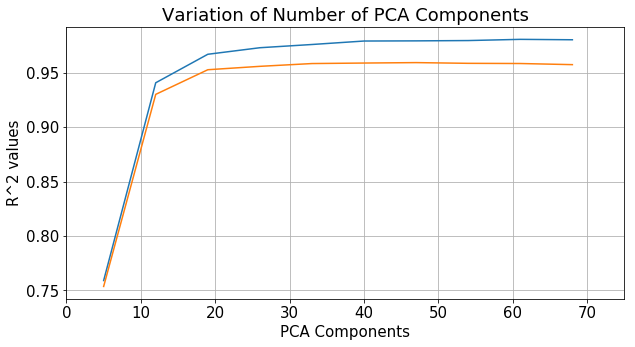

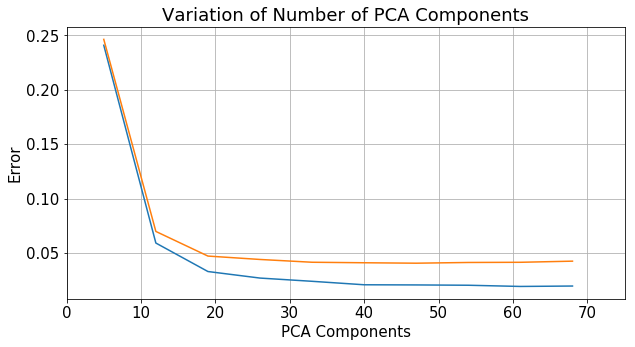

In [208]:
def N_PCA_SVM(N_comp_max, X_train, y_train, X_val, y_val):
     
    n_train, m_train = X_train.shape
    
    N_range = range(5, N_comp_max,7)
    
    f1_train = np.zeros(len(N_range))
    f1_val = np.zeros(len(N_range))
    f1_train_error = np.zeros(len(N_range))
    f1_val_error = np.zeros(len(N_range))
    
    cnt = 0
    
    for i in tqdm(N_range):
        
        (pca, _) = PCArun(i, X_train)
       
        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        # Apply classifcation model
        svm_model = svm.SVC()
        svm_model.fit(X_train_pca, y_train)
        
        # predict the labels values 
        y_train_pred = svm_model.predict(X_train_pca)
        y_val_pred = svm_model.predict(X_val_pca)
        
        f1_train[cnt] = f1_score(y_train, y_train_pred, average='macro')
        f1_val[cnt] = f1_score(y_val, y_val_pred, average='macro')
        
        f1_train_error[cnt] = 1 -  f1_train[cnt]
        f1_val_error[cnt] = 1 -  f1_val[cnt]
        
        cnt = cnt + 1
        
    plt.figure()
    plt.plot(N_range, f1_train)
    plt.plot(N_range,f1_val)
    plt.xlabel('PCA Components')
    plt.ylabel('R^2 values')
    plt.grid(True)
    plt.xlim(0,N_comp_max)
    plt.legend(['Train', 'Validation'])
    
    plt.figure()
    plt.plot(N_range, f1_train_error)
    plt.plot(N_range,f1_val_error)
    plt.xlabel('PCA Components')
    plt.ylabel('Error')
    plt.grid(True)
    plt.xlim(0,N_comp_max)
    plt.legend(['Train', 'Validation'])
              
N_PCA_SVM(75, X_train_std, y_train, X_val_std, y_val)

### Apply PCA-SVM model to the y_test data

Randomly selected Y_test samples and their predicted values using the PCA and SVM


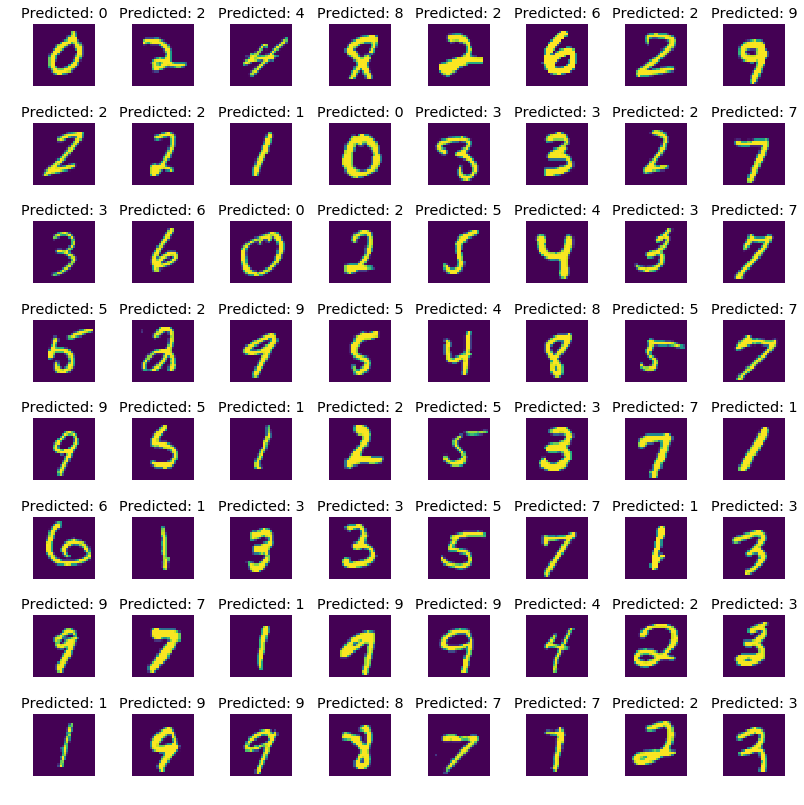

In [210]:
print('Randomly selected Y_test samples and their predicted values using the PCA and SVM')
font = {'size'   : 12}
mpl.rc('font', **font)
PlotTest(64, X_test, y_test_pred)



### Intermediate Values

Out of interest lets take a look at the intermediate values, the Eigen values and the PCA reduced transformations



Below are the top Eigenvalues in order of Highest variance:


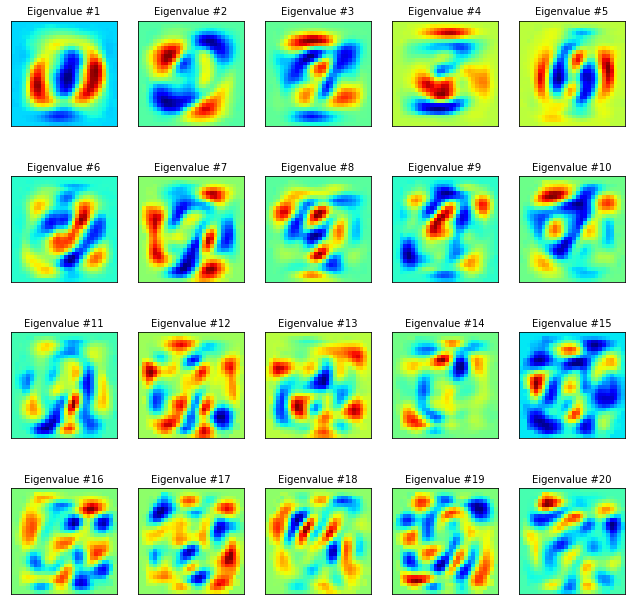

Below are an few samples of the images with reduced dimensionality


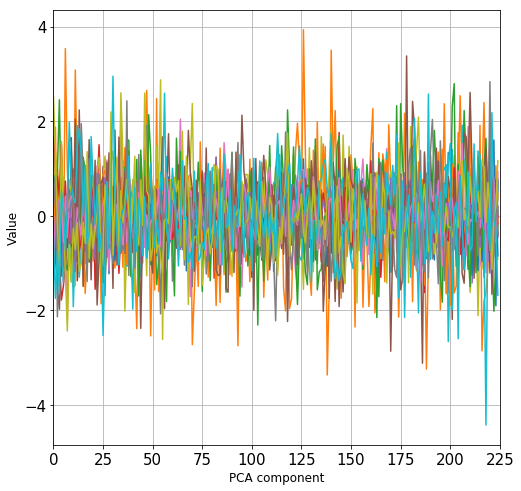

In [192]:

print('\n\nBelow are the top Eigenvalues in order of Highest variance:')
N_components = 16
pca, eigen_val_pca = PCA_Eigen(N_components, X_train_std)

PlotEigen(30, eigen_val_pca)

X_train_pca = pca.transform(X_train_std)

print('Below are an few samples of the images with reduced dimensionality')
plt.figure(figsize = [8,8])
for i in range(20):
    plt.plot(X_train_pca[i,:])
plt.xlabel('PCA component')    
plt.ylabel('Value') 
plt.xlim(0,N_components)
plt.grid(True)



In [ ]:
Using a differenc solver

https://www.kaggle.com/bhill13/oooonnnneee-is-the-loneliest-number/notebook